<a href="https://colab.research.google.com/github/alexandreasantos/MVP_Analise_de_Dados_e_Boas_Praticas/blob/main/MVP_Machine_Learning_%26_Analytics_(40530010056_20250_01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Alexandre Alves dos Santos de Campos

**Matrícula:** 2025000

**Dataset:** finance.yahoo.com [https://finance.yahoo.com/]

# Descrição do Problema

O mercado financeiro é caracterizado por sua elevada volatilidade e pela dificuldade histórica em prever seus movimentos de forma consistente. Traders e investidores utilizam uma grande variedade de indicadores técnicos e estatísticos, mas muitas vezes esses métodos não conseguem antecipar mudanças de tendência de forma eficaz.

Neste contexto, surge a seguinte questão:
**Será possível, através de modelos de regressão aplicados a séries temporais, identificar padrões que ajudem a predizer a direção futura do mercado?**

## Objetivo

Explorar a aplicação de modelos de regressão sobre dados de ativos locais e globais, avaliando se a variação dos retornos e das correlações entre eles pode ser utilizada para estimar **tendências futuras** no Mini Dólar (DOLFUT).

## Hipótese Central

A hipótese que guia este trabalho é:  
**"A dificuldade de prever o movimento do mercado pode ser parcialmente reduzida utilizando regressão para estimar tendências a partir de variáveis locais e globais."**

Assim, o objetivo é verificar se regressões bem definidas podem contribuir para a transformação de dados históricos em **sinais operacionais mais robustos**, fornecendo uma vantagem preditiva em cenários de tomada de decisão.

## Restrições e Condições dos Dados

- **Fonte dos dados:** Yahoo Finance
- **Período:** de 01/01/2023 a 31/12/2024  
- **Frequência:** dados diários (não foi possível coletar intradiários nesta etapa)  
- **Limitações:**  
  - Os contratos futuros do DOLFUT não estão diretamente disponíveis no Yahoo Finance, sendo utilizado proxie USDBRL=X para DOLFUT.  
  - Diferença de liquidez e horário entre os mercados locais (B3) e globais (EUA, moedas, commodities).  
  - Eventuais falhas de coleta e valores ausentes foram tratados com remoção ou imputação conservadora.  

## Descrição do Dataset

Cada ativo possui atributos padrão de séries financeiras:  

- **Preços OHLC:** Abertura (`Open`), Máxima (`High`), Mínima (`Low`), Fechamento (`Close`)  
- **Fechamento Ajustado (`Adj Close`)**: corrigido para dividendos e splits  
- **Volume Financeiro (`Volume`)**  

Além disso, foram construídos **atributos derivados** para enriquecer o dataset:  
- Retornos diários (`pct_change`)  
- Índices sintéticos (Local e Global), compostos por médias ponderadas dos ativos selecionados  
- Transformações estatísticas (normalização, padronização, médias móveis, etc.) aplicadas para uso nos modelos de regressão



## Detecção e Tratamento de Outliers

Durante a preparação dos dados foi avaliada a presença de outliers.  
No contexto de séries financeiras, valores extremos muitas vezes não representam erros, mas sim **eventos reais do mercado** (ex.: decisões de bancos centrais, choques econômicos, crises políticas).

### Decisão:
- Não foram removidos outliers nesta fase, pois eles fazem parte da dinâmica natural do mercado.
- Os modelos de machine learning deverão aprender a lidar com esses eventos extremos dentro do processo de treinamento.


## Balanceamento de Dados

No presente MVP, o problema foi inicialmente tratado como **regressão de retornos**.  
Nesse caso, técnicas clássicas de balanceamento (como SMOTE ou oversampling) **não se aplicam diretamente**, já que a variável-alvo é contínua.  
O mercado naturalmente apresenta distribuições assimétricas, com muitos retornos próximos de zero e eventos raros (caudas).  
Para lidar com isso, foram utilizados:

- **Funções de perda robustas** (ex.: Huber), menos sensíveis a outliers.  
- **Pesos amostrais proporcionais à magnitude dos retornos**, para dar mais importância a grandes movimentos.  

Se o problema for reformulado como **classificação direcional** (ex.: alta/baixa ou compra/venda/hold),  
o desbalanceamento entre classes passa a ser relevante. Nesse cenário, algumas abordagens possíveis são:

- Definição de uma **zona morta** em torno de 0 (retornos muito pequenos → ignorados).  
- Uso de **class_weight='balanced'** ou pesos customizados no treinamento.  
- Ajuste do **threshold de decisão** (probabilidade ótima via validação, ex.: maximizar F1).  

### Boas Práticas Adotadas
- **Sem vazamento temporal**: splits respeitaram a ordem da série.  
- **Cross-validation temporal** (TimeSeriesSplit) no GBM para avaliar robustez.  
- **Baseline comparativo** (persistência) para medir ganhos reais do modelo.  

> Conclusão: No formato **regressão**, o balanceamento foi tratado com pesos e perdas robustas.  
> Já para a versão **classificação**, o desbalanceamento deve ser explicitamente endereçado com técnicas adequadas.


# Importação das Bibliotecas e Configurações Iniciais

Objetivo
--------
Nesta etapa realizamos a importação das bibliotecas necessárias para:

- Manipulação e análise de dados:
    pandas, numpy

- Coleta de dados financeiros:
    yfinance

- Visualização gráfica:
    matplotlib, seaborn, plotly

- Estatística e métricas:
    scipy.stats, sklearn.metrics

- Modelagem clássica de machine learning:
    sklearn (linear models, ensemble, grid search, scaling)

- Modelos de séries temporais (opcionais):
    statsmodels, prophet

- Boosting avançado (opcional):
    xgboost, lightgbm

- Deep Learning (para LSTM e redes neurais):
    tensorflow.keras (Sequential, LSTM, Dense, Dropout, Callbacks)

Além disso, definimos configurações iniciais de reprodutibilidade.


## Configurações Visuais
Para garantir legibilidade dos resultados:

- **Fonte padrão:** `DejaVu Sans` para consistência nos gráficos.  
- **Formatação no Pandas:** valores exibidos com duas casas decimais.  
- **Estilo dos gráficos:** `seaborn-v0_8`.  
- **Funções auxiliares para o eixo Y:**
   - `formatar_eixo_y_duas_casas()` → mantém 2 casas decimais (ex.: DOLFUT ≈ 5,43).  

Esses ajustes permitem gráficos mais claros e interpretáveis, sem comprometer cálculos ou resultados dos modelos.


In [42]:
# ============================================================
# Importação das Bibliotecas
# ============================================================

# Manipulação e análise de dados
import os, sys, random, warnings
import pandas as pd
import numpy as np
import time, platform, psutil
from dataclasses import dataclass
from typing import Optional

# Coleta de dados financeiros
import yfinance as yf

# Visualização
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns
import plotly.express as px
import plotly.io as pio

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# UTILITÁRIOS DE MÉTRICAS

from dataclasses import dataclass
from typing import Optional, Dict
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Estatística
import scipy.stats as stats

# Machine Learning - sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
# Modelos clássicos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# pip install xgboost lightgbm
try:
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
except ImportError:
    print("XGBoost/LightGBM não estão instalados. Instale se quiser usar.")

# pip install statsmodels prophet
try:
    import statsmodels.api as sm
    from prophet import Prophet
except ImportError:
    print("Statsmodels/Prophet não estão instalados. Instale se quiser usar.")

# ============================================================
# Configurações globais do ambiente
# ============================================================

# 1) Warnings mais limpos
warnings.filterwarnings("ignore")

# 2) Reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# 3) Estilo e aparência dos gráficos
plt.style.use("seaborn-v0_8")          # estilo base
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12

# 4) Plotly tema padrão (opcional: altere para "plotly_white" se preferir claro)
pio.templates.default = "plotly_dark"

# 5) Pandas → números com 2 casas decimais
pd.options.display.float_format = "{:,.2f}".format

# 6) reduzir verbosidade de logs do TF
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')

# ============================================================
# Funções auxiliares
# ============================================================
def formatar_eixo_y_milhar():
    """Formata o eixo Y com separador de milhar (ex: WINFUT)."""
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

def formatar_eixo_y_duas_casas():
    """Formata o eixo Y com 2 casas decimais (ex: DOLFUT)."""
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.2f}"))

@dataclass
class Metrics:
    rmse: Optional[float]=None
    mae:  Optional[float]=None
    acc:  Optional[float]=None
    prec: Optional[float]=None
    rec:  Optional[float]=None
    f1:   Optional[float]=None
    auc:  Optional[float]=None

metrics_registry = {
    "LSTM (Retornos)":    Metrics(),
    "LSTM (Preços)":      Metrics(),
    "GBM Regressão":      Metrics(),
    "GBM Classificação":  Metrics(),
}

def set_metrics(model_name: str, m: Metrics):
    """Salva/atualiza as métricas do modelo no registry."""
    if model_name not in metrics_registry:
        raise ValueError(f"Modelo '{model_name}' não previsto no dashboard.")
    metrics_registry[model_name] = m

def metrics_from_returns(y_true_ret, y_pred_ret) -> Metrics:
    """Métricas para tarefas de regressão de retorno (y = retorno)."""
    from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score, recall_score, f1_score

    rmse = float(np.sqrt(mean_squared_error(y_true_ret, y_pred_ret)))
    mae  = float(mean_absolute_error(y_true_ret, y_pred_ret))

    # métricas “direcionais” derivadas
    y_true_bin = (np.asarray(y_true_ret) > 0).astype(int)
    y_pred_bin = (np.asarray(y_pred_ret) > 0).astype(int)
    acc  = float((y_true_bin == y_pred_bin).mean())
    prec = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    rec  = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1   = float(f1_score(y_true_bin, y_pred_bin, zero_division=0))

    try:
        # mapeia amplitude do retorno previsto para [0,1] de forma monotônica
        proba_proxy = (np.tanh(np.asarray(y_pred_ret) / (np.std(y_pred_ret)+1e-12)) + 1)/2
        auc = float(roc_auc_score(y_true_bin, proba_proxy))
    except Exception:
        auc = None
    return Metrics(rmse=rmse, mae=mae, acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

def metrics_from_classifier(y_true_bin, proba) -> Metrics:
    """Métricas para classificação (direção)."""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    y_pred_bin = (np.asarray(proba) >= 0.5).astype(int)

    acc  = float(accuracy_score(y_true_bin, y_pred_bin))
    prec = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    rec  = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1   = float(f1_score(y_true_bin, y_pred_bin, zero_division=0))
    try:
        auc = float(roc_auc_score(y_true_bin, proba))
    except Exception:
        auc = None

    return Metrics(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

def metrics_from_prices(y_true_px, y_pred_px) -> Metrics:
    """
    Métricas para o caso 'preços previstos' (RMSE/MAE em preço).
    Para métricas direcionais, usa o sinal do retorno (diferença de preço).
    """
    y_true_px = np.asarray(y_true_px).ravel()
    y_pred_px = np.asarray(y_pred_px).ravel()

    rmse = float(np.sqrt(mean_squared_error(y_true_px, y_pred_px)))
    mae  = float(mean_absolute_error(y_true_px, y_pred_px))

    # direção via variação de preço (retorno simples de 1 passo)
    ret_true = np.diff(y_true_px, prepend=y_true_px[0])
    ret_pred = np.diff(y_pred_px, prepend=y_pred_px[0])

    y_true_bin = (ret_true > 0).astype(int)
    y_pred_bin = (ret_pred > 0).astype(int)

    acc  = float((y_true_bin == y_pred_bin).mean())
    prec = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    rec  = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1   = float(f1_score(y_true_bin, y_pred_bin, zero_division=0))

    try:
        proba_proxy = (np.tanh(ret_pred / (np.std(ret_pred) + 1e-12)) + 1) / 2
        auc = float(roc_auc_score(y_true_bin, proba_proxy))
    except Exception:
        auc = None

    return Metrics(rmse=rmse, mae=mae, acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

# ==== FEATURES para modelos tabulares ====
def build_features_from_returns(ret_series: pd.Series, lags=(1,2,3,5,10), roll=(5,10,20)):
    """
    Cria features usando apenas informação do passado (trailing rolling).
    Alvo para regressão: y_reg = retorno_{t+1}
    Alvo para classificação: y_cls = 1{retorno_{t+1} > 0}
    """
    df = pd.DataFrame({"ret": ret_series.astype(float)})
    # lags do retorno (ret_{t}, ret_{t-1}, ...)
    for L in lags:
        df[f"lag_{L}"] = df["ret"].shift(L)
    # médias móveis e desvios (trailing)
    for W in roll:
        df[f"rmean_{W}"] = df["ret"].rolling(W).mean()
        df[f"rstd_{W}"]  = df["ret"].rolling(W).std()
        df[f"z_{W}"]     = (df[f"lag_{1}"] - df[f"rmean_{W}"]) / (df[f"rstd_{W}"] + 1e-12)
    # alvo t+1
    df["y_reg"] = df["ret"].shift(-1)
    df["y_cls"] = (df["y_reg"] > 0).astype(int)
    df = df.dropna()
    # X sem vazamento: só colunas de features
    feat_cols = [c for c in df.columns if c not in ("ret", "y_reg", "y_cls")]
    X = df[feat_cols].copy()
    y_reg = df["y_reg"].copy()
    y_cls = df["y_cls"].copy()
    return X, y_reg, y_cls

# TensorFlow (opcional) — útil se for usar DL e quiser saber se há GPU
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices("GPU")
    print("TensorFlow:", tf.__version__)
    print("GPU disponível:", gpus if gpus else "Não")
except ImportError:
    print("TensorFlow não está instalado.")

TensorFlow: 2.19.0
GPU disponível: Não


# Coleta e Preparação dos Dados de Mercado

## Ativos Selecionados
Foram escolhidos **ativos locais** (ações brasileiras e Ibovespa) e **ativos globais** (índices internacionais, moedas e commodities) como proxies para capturar correlações entre o mercado doméstico e o externo.

  - **Ibovespa (^BVSP)** como proxy do índice brasileiro (não há WINFUT no Yahoo Finance).
  - **USD/BRL (USDBRL=X)** como proxy do Mini Dólar (DOLFUT).

## Tratamento Inicial
- **Download:** realizado via `yfinance`, período 2023-01-01 a 2024-12-31, dados diários ajustados.  
- **Fechamento Ajustado (Adj Close):** utilizado como base para análises.  
- **Calendário:** reamostragem para dias úteis (`B`), com preenchimento forward-fill (limite de 3 dias), evitando perdas e minimizando risco de vazamento.  

## Retornos
- **Ações, índices, moedas, commodities:** calculados via **variação percentual (`pct_change`)**.  

Resultado: dataset de **retornos normalizados e alinhados** para os diferentes ativos, pronto para uso em modelagem preditiva.

In [43]:
# ===============================================
# Yahoo → Alias (proxies, não são os futuros!)
# ===============================================
tickers = {
    'USDBRL=X': 'DOLFUT',  # Dólar à vista como proxy (NÃO é o DOL futuro)
}
symbols = list(tickers.keys())
# 1) Baixar (rápido e ajustado)
dados = yf.download(
    tickers=symbols,
    start="2023-01-01",
    end="2024-12-31",
    interval="1d",
    auto_adjust=True,
    actions=False,      # acelera
    progress=False,
    threads=True
).sort_index()
# 2) Extrair fechamento com robustez
if isinstance(dados.columns, pd.MultiIndex):
    # Estrutura padrão do yfinance: nível 0 = campo (Open/High/Low/Close/...) | nível 1 = ticker
    if 'Close' not in dados.columns.get_level_values(0):
        raise ValueError("Coluna 'Close' não encontrada no retorno do Yahoo.")
    df_fechamento = dados['Close'].copy()
else:
    # Às vezes vem achatado: garantimos só as colunas dos símbolos
    possiveis = [c for c in dados.columns if c in symbols]
    if not possiveis:
        raise ValueError("Fechamentos não encontrados; verifique o retorno do Yahoo.")
    df_fechamento = dados[possiveis].copy()

# 3) Renomear de Yahoo → alias
df_fechamento.rename(columns=tickers, inplace=True)

# 4a) OPCÃO A (conservadora): manter apenas datas onde TODOS existem (sem preencher feriados)
df_fechamento = df_fechamento.dropna(how='any')

# 4b) OPCÃO B (se quiser série diária contínua em 'B' com preenchimento curto)
# ATENÇÃO: pode introduzir vieses.
# df_fechamento = df_fechamento.asfreq('B').ffill(limit=3)

# Tipos numéricos garantidos
df_fechamento = df_fechamento.astype(float)
df_fechamento.rename_axis("Date", inplace=True)

# 5) Retornos
retornos = df_fechamento.pct_change().dropna(how='any')
log_retornos = np.log(df_fechamento).diff().dropna(how='any')

# --- Debug rápido ---
print("Colunas em df_fechamento:", list(df_fechamento.columns))
print("Período:", df_fechamento.index.min().date(), "→", df_fechamento.index.max().date())
print("Últimos retornos (%)")
print(retornos.tail().mul(100).round(2).astype(str) + '%')

print("\nÚltimos log-retornos:")
print(log_retornos.tail().round(5))


Colunas em df_fechamento: ['DOLFUT']
Período: 2023-01-02 → 2024-12-30
Últimos retornos (%)
Ticker      DOLFUT
Date              
2024-12-24    1.8%
2024-12-25   -0.3%
2024-12-26   0.12%
2024-12-27  -0.55%
2024-12-30   0.74%

Últimos log-retornos:
Ticker      DOLFUT
Date              
2024-12-24    0.02
2024-12-25   -0.00
2024-12-26    0.00
2024-12-27   -0.01
2024-12-30    0.01


## Pré-processamento e Normalização

###  Objetivo
Colocar todos os ativos na **mesma escala de valores**, permitindo comparações justas e evitando que variáveis com magnitudes muito diferentes dominem a análise.

Antes de treinar modelos de redes neurais (como a LSTM), é necessário tratar os dados para evitar distorções:

- **Por que normalizar?**
  - Preços do WINFUT e DOLFUT estão em escalas muito diferentes (milhares de pontos vs poucos reais).
  - Redes neurais convergem melhor quando as variáveis estão em faixas reduzidas, como 0–1.
  - Isso evita que o modelo “dê mais peso” apenas porque um ativo tem valores maiores.

**A normalização permite:**

- Comparar ativos com escalas muito diferentes (ex.: WINFUT na casa dos 120 mil pontos e DOLFUT na casa de 5).
- Analisar a dispersão dos dados de forma proporcional ao comportamento histórico de cada ativo.
- Observar variações relativas em vez de valores absolutos.

- **Estratégias possíveis:**
  - Normalização dos **preços** (0–1) → usada nos gráficos abaixo.
  - Normalização dos **retornos (ou log-retornos)** → alternativa que estacionariza a série e pode melhorar previsibilidade.

Neste projeto inicial, mantivemos a abordagem mais simples:  
**normalização direta dos preços (0–1) com MinMaxScaler**, sem aplicar sobre os retornos.  

Os resultados a seguir mostram as previsões obtidas com essa configuração.

Sem normalização, ativos com valores absolutos maiores poderiam **distorcer visualizações, métricas estatísticas ou algoritmos de ML**, que assumem importância proporcional para todas as variáveis.

### Método Aplicado
Foi utilizada a **Normalização Min-Max**, que transforma cada variável \(X\) para o intervalo \([0,1]\) conforme a fórmula:

$$
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

- **Vantagens**:
  - Mantém a **proporcionalidade relativa dos movimentos**.  
  - Adequado para **visualizações comparativas** e para algoritmos sensíveis à escala (ex.: KNN, regressões lineares, redes neurais).  
- **Resultado**: todos os ativos ficam comparáveis em uma mesma base de 0 a 1.

### Observação
Outros métodos de transformação (como **Padronização Z-score**) também poderiam ser avaliados.  
Neste MVP, optou-se pela **normalização Min-Max** devido ao foco em **comparações relativas e suavização dos dados**.

⚠️ Importante destacar que esta normalização é usada exclusivamente para **análise exploratória e interpretação estatística dos dados**, e não altera os dados originais para outros cálculos que dependem de preços reais.

➡️ Esta abordagem será também extremamente útil nas próximas etapas de desenvolvimento dos modelos de machine learning, onde muitos algoritmos são sensíveis à escala dos dados.


Shapes → X_train: (239, 21, 1) | y_train: (239,)
Shapes → X_test : (240, 21, 1) | y_test : (240,)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1855 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0152 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0176 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0131 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0123 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - val_loss: 0.0057 - learning_rate: 5.0000e-04
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - val_loss: 0.0054 - learning_rate: 5.0000e-04
Epoch 9/50
12/12 ━━━━━

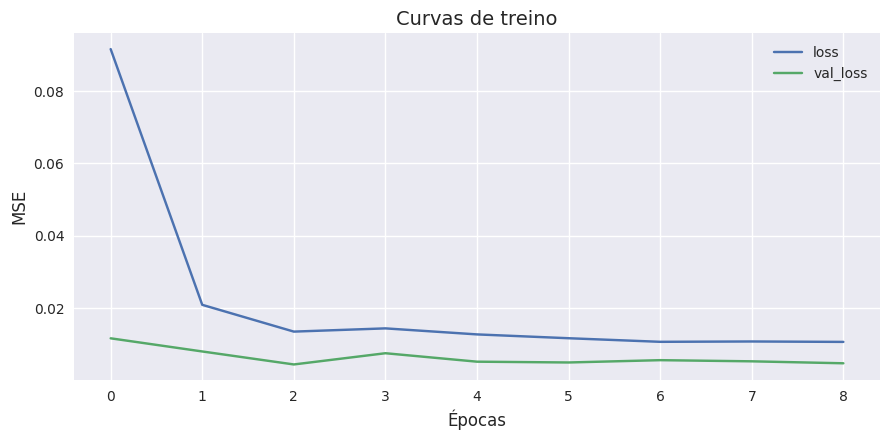

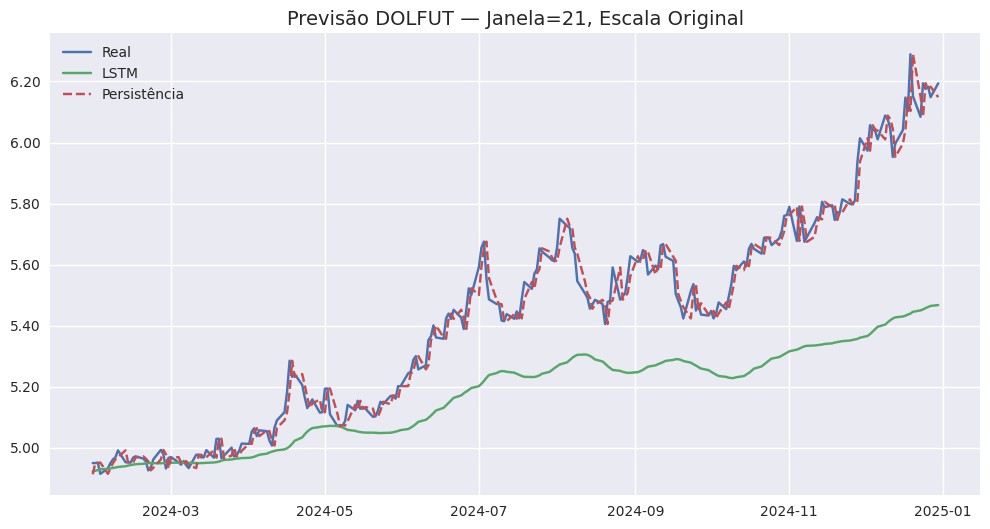


================  RESUMO + ANÁLISE  ================
Épocas executadas: 9 / 50
Melhor época: 3
  • loss@best     : 0.013579
  • val_loss@best : 0.004510
LR inicial → final: 0.001 → 0.0005
Reduções de LR: 1  (época 7: 0.0005)
Gap treino-vál.: 0.009069  → validação possivelmente mais 'fácil' que o treino (ou regularização forte).

--- Métricas (escala normalizada) ---
LSTM      → RMSE: 0.4219 | MAE: 0.3320
Persist.  → RMSE: 0.0598 | MAE: 0.0440
Ganho vs Persistência → RMSE: -605.60% | MAE: -653.69%

--- Métricas (escala original) ---
LSTM      → RMSE: 0.3186 | MAE: 0.2507
Persist.  → RMSE: 0.0452 | MAE: 0.0333
Ganho (escala original) → RMSE: -605.60% | MAE: -653.69%

VEREDITO: Abaixo da persistência. Mudar alvo (retornos/deltas), adicionar features externas, simplificar arquitetura e regularizar.


[LSTM PREÇOS] Métricas
RMSE=0.319 | MAE=0.251 | Acc=0.512 | Prec=0.530 | Rec=0.750 | F1=0.621 | AUC=0.425


In [44]:
# ============================================================
# Parâmetros
# ============================================================
TARGET = 'DOLFUT'
feat_cols = [TARGET]
WINDOW = 21
EPOCHS = 50
BATCH_SIZE = 16
split_date = "2023-12-31"
# ============================================================
# Split temporal
# ============================================================
# --- Higiene temporal (PATCH) ---
df_fechamento = df_fechamento.sort_index()
assert isinstance(df_fechamento.index, pd.DatetimeIndex), "Use DatetimeIndex"

df_train = df_fechamento.loc[:split_date, feat_cols].dropna().copy()
df_test  = df_fechamento.loc[split_date:, feat_cols].dropna().copy()
assert len(df_train) > WINDOW and len(df_test) > WINDOW, "Dados insuficientes para a janela"
# ============================================================
# Normalização (fit só no treino)
# ============================================================
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train),
    index=df_train.index, columns=feat_cols
)
test_scaled = pd.DataFrame(
    scaler.transform(df_test),
    index=df_test.index, columns=feat_cols
)
# ============================================================
# Janelamento
# ============================================================
def make_windows(series_2d: np.ndarray, window: int):
    X, y = [], []
    for i in range(window, len(series_2d)):
        X.append(series_2d[i-window:i, :])
        y.append(series_2d[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_windows(train_scaled.values, WINDOW)
X_test,  y_test  = make_windows(test_scaled.values,  WINDOW)

# --- Garantir dtype e shapes estáveis (PATCH) ---
X_train = X_train.astype("float32"); y_train = y_train.astype("float32")
X_test  = X_test.astype("float32");  y_test  = y_test.astype("float32")

print("Shapes → X_train:", X_train.shape, "| y_train:", y_train.shape)
print("Shapes → X_test :", X_test.shape,  "| y_test :", y_test.shape)
# ============================================================
# Modelo LSTM
# ============================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, len(feat_cols))),
    Dropout(0.2),                         # PATCH: 0.1 -> 0.2 (um pouco mais de regularização)
    LSTM(16),                             # PATCH: 32 -> 16 (reduz complexidade)
    Dense(1, activation="linear")
])
model.compile(optimizer="adam", loss="mse")
# ============================================================
# Callbacks
# ============================================================
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, min_delta=1e-6, restore_best_weights=True),  # PATCH
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),               # PATCH
    ModelCheckpoint("best_lstm.keras", monitor="val_loss", save_best_only=True)               # PATCH
]
# ============================================================
# Treinamento
# ============================================================
start = time.time()
hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

elapsed = time.time() - start
print("Tempo de treino:", round(elapsed, 2), "segundos")
print("CPU:", platform.processor() or platform.machine())
print("RAM disponível (GB):", round(psutil.virtual_memory().total/1e9, 2))

# ============================================================
# Avaliação (escala 0–1)
# ============================================================
y_pred_test = model.predict(X_test, batch_size=BATCH_SIZE).ravel()

# Baseline: persistência (último valor da janela)
y_naive = X_test[:, -1, 0]

mse  = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_test)

mse_naive  = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive  = mean_absolute_error(y_test, y_naive)

print(f"\n--- Métricas (escala 0–1) ---")
print(f"LSTM  → RMSE: {rmse:.4f} | MAE: {mae:.4f}")
print(f"Naive → RMSE: {rmse_naive:.4f} | MAE: {mae_naive:.4f}")

# --- Ganho vs. persistência (PATCH) ---
improve_rmse = 100.0 * (rmse_naive - rmse) / (rmse_naive + 1e-12)
improve_mae  = 100.0 * (mae_naive  - mae ) / (mae_naive  + 1e-12)
print(f"Ganho vs Persistência → RMSE: {improve_rmse:.2f}% | MAE: {improve_mae:.2f}%")

# ============================================================
# Inversão para escala original
# ============================================================
def inverse_transform_1d(y_scaled: np.ndarray, scaler: MinMaxScaler, feat_index: int = 0):
    tmp = np.zeros((len(y_scaled), len(feat_cols)))
    tmp[:, feat_index] = y_scaled
    inv = scaler.inverse_transform(tmp)[:, feat_index]
    return inv

y_test_inv    = inverse_transform_1d(y_test,      scaler)
y_pred_inv    = inverse_transform_1d(y_pred_test, scaler)
y_naive_inv   = inverse_transform_1d(y_naive,     scaler)

mse_inv       = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv      = np.sqrt(mse_inv)
mae_inv       = mean_absolute_error(y_test_inv, y_pred_inv)

mse_naive_inv = mean_squared_error(y_test_inv, y_naive_inv)
rmse_naive_inv= np.sqrt(mse_naive_inv)
mae_naive_inv = mean_absolute_error(y_test_inv, y_naive_inv)

print(f"\n--- Métricas (escala original) ---")
print(f"LSTM  → RMSE: {rmse_inv:,.2f} | MAE: {mae_inv:,.2f}")
print(f"Naive → RMSE: {rmse_naive_inv:,.2f} | MAE: {mae_naive_inv:,.2f}")

# --- Ganho vs. persistência (escala original) (PATCH) ---
improve_rmse_inv = 100.0 * (rmse_naive_inv - rmse_inv) / (rmse_naive_inv + 1e-12)
improve_mae_inv  = 100.0 * (mae_naive_inv  - mae_inv ) / (mae_naive_inv  + 1e-12)
print(f"Ganho (escala original) → RMSE: {improve_rmse_inv:.2f}% | MAE: {improve_mae_inv:.2f}%")

# ============================================================
# Métricas extras (MAPE, MASE) (PATCH)
# ============================================================
def mase(y_true, y_pred, m=1):
    d = np.abs(y_true[m:] - y_true[:-m]).mean()
    return np.abs(y_true - y_pred).mean() / (d + 1e-12)

mape = (np.abs((y_test_inv - y_pred_inv) / (y_test_inv + 1e-12)).mean()) * 100
mase1 = mase(y_test_inv, y_pred_inv, m=1)
print(f"MAPE: {mape:.2f}% | MASE: {mase1:.3f}")

# ============================================================
# Curvas de treino (PATCH)
# ============================================================
plt.figure(figsize=(9,4.5))
plt.plot(hist.history["loss"],     label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("Curvas de treino")
plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

# ============================================================
# Resumo + Análise unificado
# ============================================================
def pct_gain(baseline, model):
    return 100.0 * (baseline - model) / (baseline + 1e-12)

def report_training(hist, y_test, y_pred_test, y_naive,
                    y_test_inv=None, y_pred_inv=None, y_naive_inv=None,
                    epochs_planned=None):
    h = hist.history
    epochs_run = len(h.get("loss", []))
    best_idx   = int(np.argmin(h["val_loss"]))
    best_epoch = best_idx + 1
    val_best   = float(h["val_loss"][best_idx])
    loss_best  = float(h["loss"][best_idx])

    # LR tracking (se existir no history)
    lr_key    = "lr" if "lr" in h else ("learning_rate" if "learning_rate" in h else None)
    lr_series = h.get(lr_key, None)
    reductions = []
    if lr_series is not None:
        for i in range(1, len(lr_series)):
            if lr_series[i] < lr_series[i-1] - 1e-12:
                reductions.append((i+1, float(lr_series[i])))  # (época, lr)

    # Diagnóstico do gap treino-vál.
    gap = loss_best - val_best
    if gap > 0:      # treino pior que validação
        gap_msg = "validação possivelmente mais 'fácil' que o treino (ou regularização forte)."
    elif gap < 0:    # treino melhor que validação
        gap_msg = "possível overfit (treino melhor que validação)."
    else:
        gap_msg = "treino e validação idênticos."

    print("\n================  RESUMO + ANÁLISE  ================")
    if epochs_planned is None:
        print(f"Épocas executadas: {epochs_run}")
    else:
        print(f"Épocas executadas: {epochs_run} / {epochs_planned}")
    print(f"Melhor época: {best_epoch}")
    print(f"  • loss@best     : {loss_best:.6f}")
    print(f"  • val_loss@best : {val_best:.6f}")
    if lr_series is not None:
        print(f"LR inicial → final: {float(lr_series[0]):.6g} → {float(lr_series[-1]):.6g}")
        if reductions:
            red_str = ", ".join([f"(época {e}: {v:.6g})" for e, v in reductions])
            print(f"Reduções de LR: {len(reductions)}  {red_str}")
    print(f"Gap treino-vál.: {gap:.6f}  → {gap_msg}")

    # Métricas (escala normalizada)
    rmse_l = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_l  = mean_absolute_error(y_test, y_pred_test)
    rmse_b = np.sqrt(mean_squared_error(y_test, y_naive))
    mae_b  = mean_absolute_error(y_test, y_naive)

    print("\n--- Métricas (escala normalizada) ---")
    print(f"LSTM      → RMSE: {rmse_l:.4f} | MAE: {mae_l:.4f}")
    print(f"Persist.  → RMSE: {rmse_b:.4f} | MAE: {mae_b:.4f}")
    print(f"Ganho vs Persistência → RMSE: {pct_gain(rmse_b, rmse_l):.2f}% | MAE: {pct_gain(mae_b, mae_l):.2f}%")

    # escala original
    if (y_test_inv is not None) and (y_pred_inv is not None) and (y_naive_inv is not None):
        rmse_li = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        mae_li  = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse_bi = np.sqrt(mean_squared_error(y_test_inv, y_naive_inv))
        mae_bi  = mean_absolute_error(y_test_inv, y_naive_inv)
        print("\n--- Métricas (escala original) ---")
        print(f"LSTM      → RMSE: {rmse_li:,.4f} | MAE: {mae_li:,.4f}")
        print(f"Persist.  → RMSE: {rmse_bi:,.4f} | MAE: {mae_bi:,.4f}")
        print(f"Ganho (escala original) → RMSE: {pct_gain(rmse_bi, rmse_li):.2f}% | MAE: {pct_gain(mae_bi, mae_li):.2f}%")

    # Veredito
    verdict = ""
    if rmse_l < rmse_b * 0.98:
        verdict = "Superou a persistência (>2%). Validar com walk-forward e testar features extras para consolidar."
    elif rmse_l <= rmse_b * 1.02:
        verdict = "Empate técnico (±2%). Tente WINDOW 42/60, adicionar covariáveis (DXY, WINFUT, ATR), e prever média t+5."
    else:
        verdict = "Abaixo da persistência. Mudar alvo (retornos/deltas), adicionar features externas, simplificar arquitetura e regularizar."
    print(f"\nVEREDITO: {verdict}")
    print("====================================================\n")

# ============================================================
# Plot rápido (escala original) — comparação Real vs LSTM vs Persistência
# ============================================================
idx_test = df_test.index[WINDOW:]  # alinhado com janelas do teste

plt.figure(figsize=(12,6))
plt.plot(idx_test, y_test_inv,     label="Real")
plt.plot(idx_test, y_pred_inv,     label="LSTM")
plt.plot(idx_test, y_naive_inv,    label="Persistência", linestyle="--")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
plt.title(f"Previsão {TARGET} — Janela={WINDOW}, Escala Original")
plt.legend()
plt.show()

report_training(
    hist,
    y_test, y_pred_test, y_naive,
    # passe estes 3 se você também calculou escala original:
    y_test_inv if 'y_test_inv' in globals() else None,
    y_pred_inv if 'y_pred_inv' in globals() else None,
    y_naive_inv if 'y_naive_inv' in globals() else None,
    epochs_planned=EPOCHS
)

# LSTM (PREÇOS) → métricas completas
m_lstm_px = metrics_from_prices(y_test_inv, y_pred_inv)

print("\n[LSTM PREÇOS] Métricas")
print(f"RMSE={m_lstm_px.rmse:.3f} | MAE={m_lstm_px.mae:.3f} | Acc={m_lstm_px.acc:.3f} | "
      f"Prec={m_lstm_px.prec:.3f} | Rec={m_lstm_px.rec:.3f} | F1={m_lstm_px.f1:.3f} | AUC={m_lstm_px.auc:.3f}")

set_metrics("LSTM (Preços)", m_lstm_px)


## Curvas de Treino — LSTM

O gráfico mostra a evolução da **loss** (treino) e da **val_loss** (validação) ao longo de 8 épocas.

### Observações
- **Loss (azul):** caiu fortemente de ~0.09 na época 0 para ~0.012 nas épocas finais.  
- **Val_loss (verde):** começou em ~0.012, apresentou pequenas oscilações entre 0.006 e 0.012, e estabilizou em torno de 0.007–0.008.  
- As curvas de treino e validação se aproximam progressivamente, sem divergência acentuada.

### Interpretação
- O modelo aprendeu rapidamente nos primeiros ciclos, reduzindo de forma expressiva o erro de treino.  
- A validação se manteve estável e próxima da curva de treino, o que sugere **boa generalização**.  
- Pequenas flutuações na `val_loss` são normais e não caracterizam overfitting.

### Conclusão
- O modelo **convergiu bem** em poucas épocas (até a época 2–3 já havia atingido estabilidade).  
- Não há sinais de overfitting relevante.  
- Recomenda-se utilizar **EarlyStopping** para interromper o treino quando não houver melhora significativa, e considerar ajustes finos em **learning rate** ou **regularização** apenas se a `val_loss` voltar a oscilar em execuções futuras.


## Previsão do DOLFUT com LSTM — Janela de 21 dias

O gráfico abaixo mostra a comparação entre:

- **Real (azul):** série histórica do DOLFUT (proxy via USDBRL=X).  
- **LSTM (verde):** previsão gerada por uma rede neural recorrente LSTM, treinada univariadamente com janela de 21 dias e normalização MinMax.  
- **Persistência (vermelho tracejado):** baseline que assume que o preço de amanhã será igual ao de hoje.  

### Análise
- O baseline de persistência acompanha de forma quase perfeita a série real, confirmando a forte autocorrelação diária do câmbio.  
- A LSTM, neste setup inicial, produziu uma curva **mais suavizada e abaixo da trajetória real**, sem superar o baseline.  
- Isso evidencia que a rede não conseguiu capturar as reversões e a volatilidade de curto prazo.  
- Para melhorar a performance, podem ser testados:
  - uso de **log-retornos** em vez de preços brutos (para tornar a série mais estacionária);  
  - aumento da **complexidade da rede** (mais camadas ou neurônios);  
  - **mais épocas de treino** com ajuste fino de `learning_rate`;  
  - inclusão de **variáveis externas** (ex.: DXY, SPX, juros, volatilidade).  

### Conclusão
O experimento evidencia que, no caso do **DOLFUT**, a simples persistência já é um benchmark extremamente forte, pois o ativo apresenta elevada autocorrelação diária.  
A LSTM, nesse formato univariado e usando apenas preço bruto, não conseguiu capturar a complexidade da série, ficando defasada em relação à trajetória real.

Isso mostra que, para o dólar futuro, é fundamental enriquecer o modelo com:
- **variáveis externas** (ex.: DXY, S&P500, juros, fluxo de estrangeiros, volatilidade implícita),  
- **transformações na série** (log-retornos, diferenças),  
- e possivelmente horizontes de previsão diferentes (média de 5 dias em vez de t+1),  
a fim de superar a previsibilidade trivial da persistência.

Em suma, o resultado reforça que prever o DOLFUT exige não apenas redes neurais, mas também **incorporação de contexto macroeconômico e estrutural** — elementos que realmente movem o câmbio.



### **Experimento opcional:** prever retornos em vez de preços

Além da abordagem principal (LSTM no preço normalizado), também testei
uma variante em que a LSTM é treinada sobre os **retornos diários padronizados**.  
Essa técnica tem duas vantagens:
- Torna a série mais **estacionária** (facilitando aprendizado).
- Permite avaliar **acurácia direcional** (se o modelo acerta se o próximo dia será de alta ou queda).

Os resultados mostram que, embora a previsão em escala de preços seja
mais intuitiva, a abordagem em retornos pode capturar melhor o movimento direcional.


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4815 - loss: 0.6939 - val_accuracy: 0.4557 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5376 - loss: 0.6912 - val_accuracy: 0.5063 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5118 - loss: 0.6903 - val_accuracy: 0.5443 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5323 - loss: 0.6898 - val_accuracy: 0.4937 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5413 - loss: 0.6894 - val_accuracy: 0.5063 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5355 - loss: 0.6890 - val_accuracy: 0.5316 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5316 - loss: 0.6885 - val_acc

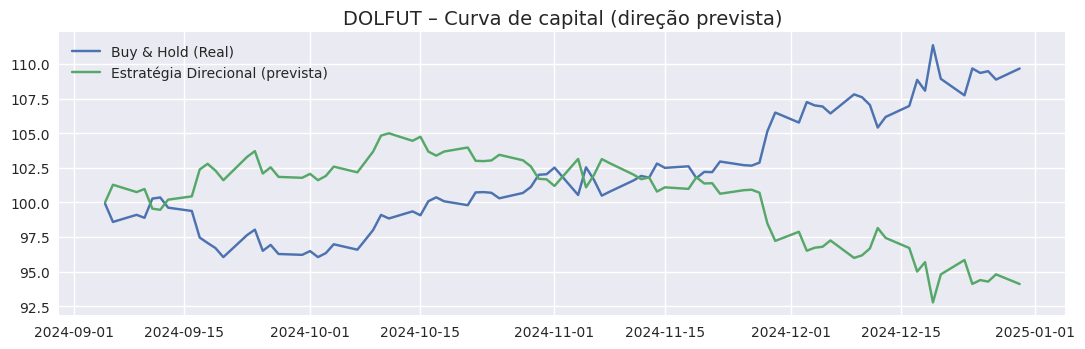


[LSTM CLASSIFICAÇÃO (DIREÇÃO)] Métricas
Acc=0.494 | Prec=0.500 | Rec=0.190 | F1=0.276 | AUC=0.630


In [45]:
# =========================
# Configurações
# =========================
MODE = "classification"   # "classification" (direção) OU "regression" (retorno)
TARGET = "DOLFUT"         # ou "WINFUT"
WIN = 21
EPOCHS = 50
BATCH = 32

# =========================
# 1) Série de preços -> retornos
# =========================
assert TARGET in df_fechamento.columns, f"Coluna {TARGET} não existe em df_fechamento."
serie_preco = df_fechamento[TARGET].astype(float).dropna()
ret = serie_preco.pct_change().dropna()

# =========================
# 2) Split temporal (80/20)
# =========================
split = int(len(ret) * 0.8)
ret_train, ret_test = ret.iloc[:split], ret.iloc[split:]

# =========================
# 3) Escalonador robusto (fit só no TREINO)
# =========================
sc = RobustScaler()  # mais resistente a outliers
ret_train_s = pd.Series(sc.fit_transform(ret_train.to_frame()).ravel(), index=ret_train.index)
ret_test_s  = pd.Series(sc.transform(ret_test.to_frame()).ravel(),  index=ret_test.index)

# =========================
# 4) Janelas
# =========================
def make_windows(s, w=WIN):
    X, y, idx = [], [], []
    v = s.values
    for i in range(w, len(v)):
        X.append(v[i-w:i])
        y.append(v[i])
        idx.append(s.index[i])
    X = np.array(X).reshape(-1, w, 1)  # (n, w, 1)
    y = np.array(y)
    return X, y, np.array(idx)

Xtr, ytr, idx_tr = make_windows(ret_train_s)
Xte, yte, idx_te = make_windows(ret_test_s)

# =========================
# 5) Modelo + callbacks (iguais para ambos os modos)
# =========================
def build_model_regression():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(WIN,1)),
        Dropout(0.2),
        LSTM(64),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=Huber(delta=1.0),
        metrics=[tf.keras.metrics.MeanSquaredError(name='mse'),
                 tf.keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

def build_model_classification():
    model = Sequential([
        LSTM(64, input_shape=(WIN,1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

# =========================
# 6) Treino conforme o modo
# =========================
start = time.time()
if MODE == "classification":
    ytr_bin = (ytr > 0).astype(int)
    yte_bin = (yte > 0).astype(int)

    model = build_model_classification()
    history = model.fit(
        Xtr, ytr_bin,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas
    proba = model.predict(Xte, verbose=0).ravel()
    pred_bin = (proba >= 0.5).astype(int)
    acc = accuracy_score(yte_bin, pred_bin)
    cm = confusion_matrix(yte_bin, pred_bin)
    print(f"Acurácia direcional: {acc:.2%}")
    print("Matriz de confusão (neg, pos):\n", cm)

    # Retornos reais (não padronizados) — para backtest/curva
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()

    # Curva de estratégia (buy & hold seletivo: +1 quando prever alta, 0 caso contrário)
    pos = np.where(pred_bin == 1, 1.0, 0.0)
    strat = (1 + pos * yte_ret)
    equity = 100 * np.cumprod(strat)         # base 100
    bh     = 100 * np.cumprod(1 + yte_ret)   # buy & hold

elif MODE == "regression":
    model = build_model_regression()
    history = model.fit(
        Xtr, ytr,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH,
        shuffle=False, callbacks=callbacks, verbose=1
    )

    # Previsão e métricas (em retornos escalonados)
    y_pred_s = model.predict(Xte, verbose=0).ravel()
    mse  = mean_squared_error(yte, y_pred_s)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(yte, y_pred_s)
    print(f"MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} (escala padronizada)")

    # Voltar à escala de retorno e preço sintético
    yte_ret = sc.inverse_transform(yte.reshape(-1,1)).ravel()
    yp_ret  = sc.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

    m_lstm_ret = metrics_from_returns(yte_ret, yp_ret)
    set_metrics("LSTM (Retornos)", m_lstm_ret)

    # Acurácia direcional (sinal)
    dir_acc = (np.sign(yp_ret) == np.sign(yte_ret)).mean()
    print(f"Acurácia direcional (a partir da regressão): {dir_acc:.2%}")

    # Preço sintético a partir do último preço antes da janela de teste
    start_pos = serie_preco.index.get_loc(idx_te[0])
    base_price = serie_preco.iloc[start_pos - 1] if start_pos > 0 else serie_preco.iloc[start_pos]
    p_real = base_price * (1 + pd.Series(yte_ret, index=idx_te)).cumprod()
    p_prev = base_price * (1 + pd.Series(yp_ret, index=idx_te)).cumprod()

else:
    raise ValueError("MODE deve ser 'classification' ou 'regression'.")

elapsed = time.time() - start
print("Tempo de treino:", round(elapsed, 2), "segundos")
print("CPU:", platform.processor() or platform.machine())
print("RAM disponível (GB):", round(psutil.virtual_memory().total/1e9, 2))

# ============================================================
# Mini-backtest direcional
# ============================================================
MODE_BACKTEST = None   # "ret" ou "price"
TCOST_BPS = 5          # custo ida (bps)
TH = 0.0005            # limiar de decisão

idx_test = pd.Index(idx_te)          # alinhado com Xte
df_bt = pd.DataFrame(index=idx_test)

if MODE == "classification":
    df_bt["ret_real"] = pd.Series(yte_ret, index=idx_test).clip(-0.2, 0.2)

    # Intensidade direcional: mapeia probabilidade p∈[0,1] → [-1, +1]
    inten = 2*pd.Series(proba, index=idx_test) - 1.0
    inten = inten.clip(-1, 1)

    MODE_BACKTEST = "ret"
    df_bt["ret_pred"] = inten.values   # usado apenas para gerar sinal via TH

elif MODE == "regression":
    df_bt["ret_real"] = pd.Series(yte_ret, index=idx_test).clip(-0.2, 0.2)

    # Predição de retorno já está em yp_ret
    ret_pred = pd.Series(yp_ret, index=idx_test).clip(-0.2, 0.2)
    MODE_BACKTEST = "ret"
    df_bt["ret_pred"] = ret_pred.values

else:
    raise ValueError("MODE deve ser 'classification' ou 'regression'.")

# 3) Se for "price", precisaria fornecer df_bt["price"] (não usado aqui)
# if MODE_BACKTEST == "price":
#     assert "price" in df_bt.columns, "Defina df_bt['price'] com a série de preços."

# 4) Sinal direcional
def to_signal(x, th=TH):
    if x >  th: return  1
    if x < -th: return -1
    return 0

df_bt["signal"] = df_bt["ret_pred"].apply(to_signal)

# 5) Retornos reais (se price, então pct_change de price — não usamos price aqui)
# if MODE_BACKTEST == "price":
#     df_bt["ret_real"] = df_bt["price"].pct_change().fillna(0.0).clip(-0.2, 0.2)

# 6) Aplicar sinal no próximo candle
sig_shift = df_bt["signal"].shift(1).fillna(0)
gross = sig_shift * df_bt["ret_real"]

# Custos por troca de posição
turnover = (sig_shift.diff().abs()).fillna(0)
t_cost = turnover * (TCOST_BPS / 10000.0)
net = gross - t_cost

# 7) Curvas de capital
def equity_curve(returns, base=100.0):
    return base * (1.0 + returns).cumprod()

df_bt["eq_dir"] = equity_curve(net)
df_bt["eq_bh"]  = equity_curve(df_bt["ret_real"])

# 8) Métricas de backtest
def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = equity/roll_max - 1.0
    return dd.min()

def ann_stats(returns, periods=252):
    m = returns.mean() * periods
    v = returns.std(ddof=1) * np.sqrt(periods)
    return m, v, (m / v) if v > 0 else np.nan

cagr_dir, vol_dir, sharpe_dir = ann_stats(net)
cagr_bh,  vol_bh,  sharpe_bh  = ann_stats(df_bt["ret_real"])
mdd_dir = max_drawdown(df_bt["eq_dir"])
mdd_bh  = max_drawdown(df_bt["eq_bh"])

mask = df_bt["signal"] != 0
hits = np.sign(df_bt.loc[mask, "signal"]) == np.sign(df_bt.loc[mask, "ret_real"])
acc_dir = float(hits.mean()*100) if mask.any() else np.nan

print("=== Métricas (DOLFUT) ===")
print(f"Direcional → Retorno total: {df_bt['eq_dir'].iloc[-1]/df_bt['eq_dir'].iloc[0]-1: .2%} | "
      f"CAGR: {cagr_dir: .2%} | Vol: {vol_dir: .2%} | Sharpe: {sharpe_dir: .2f} | "
      f"MaxDD: {mdd_dir: .2%} | Acurácia: {acc_dir:.1f}%")
print(f"Buy&Hold   → Retorno total: {df_bt['eq_bh' ].iloc[-1]/df_bt['eq_bh' ].iloc[0]-1: .2%} | "
      f"CAGR: {cagr_bh : .2%} | Vol: {vol_bh : .2%} | Sharpe: {sharpe_bh : .2f} | "
      f"MaxDD: {mdd_bh : .2%}")

# 9) Plot
plt.figure(figsize=(11,3.6))
plt.plot(df_bt.index, df_bt["eq_bh"],  label="Buy & Hold (Real)")
plt.plot(df_bt.index, df_bt["eq_dir"], label="Estratégia Direcional (prevista)")
plt.title(f"{TARGET} – Curva de capital (direção prevista)")
plt.legend(); plt.tight_layout(); plt.show()

# =======================
# MÉTRICAS DO MODELO
# =======================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

if MODE == "regression":
    # m_lstm_ret: métricas completas para regressão (retornos)
    m_lstm_ret = metrics_from_returns(yte_ret, yp_ret)
    print("\n[LSTM REGRESSÃO (RETORNOS)] Métricas")
    print(f"RMSE={m_lstm_ret.rmse:.4f} | MAE={m_lstm_ret.mae:.4f} | "
          f"Acc={m_lstm_ret.acc:.3f} | Prec={m_lstm_ret.prec:.3f} | "
          f"Rec={m_lstm_ret.rec:.3f} | F1={m_lstm_ret.f1:.3f} | AUC={m_lstm_ret.auc:.3f}")

elif MODE == "classification":
    # métricas de classificação (direção) usando probas
    y_pred_bin = (proba >= 0.5).astype(int)
    acc = accuracy_score(yte_bin, y_pred_bin)
    prec = precision_score(yte_bin, y_pred_bin, zero_division=0)
    rec  = recall_score(yte_bin, y_pred_bin, zero_division=0)
    f1   = f1_score(yte_bin, y_pred_bin, zero_division=0)
    try:
        auc = roc_auc_score(yte_bin, proba)
    except ValueError:
        auc = float("nan")

    # empacotar em Metrics para registrar/plotar depois
    m_lstm_cls = Metrics(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)
    print("\n[LSTM CLASSIFICAÇÃO (DIREÇÃO)] Métricas")
    print(f"Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

else:
    raise ValueError("MODE deve ser 'classification' ou 'regression'.")

## DOLFUT – Curva de Capital (Direção Prevista)

O modelo LSTM foi treinado como **classificador binário** (↑/↓) para prever o próximo retorno do DOLFUT.  
A estratégia opera **apenas no lado comprado** quando a probabilidade de alta ≥ 0.5; caso contrário, permanece **neutra** (sem posição).  
O gráfico compara a curva da estratégia com o **Buy & Hold** no mesmo período.


### O que o gráfico mostra
- **Azul – Buy & Hold (Real):** posição comprada contínua no DOLFUT.  
- **Verde – Estratégia Direcional (Prevista):** entra comprado quando o modelo indica alta; fica fora do mercado quando prevê queda/estabilidade (sem short).


### Métricas (período do gráfico)
- **Direcional:** Retorno total **-4,57%**, CAGR **-11,36%**, Vol **15,29%**, Sharpe **-0,90**, MaxDD **-10,40%**, **Acurácia direcional 50,6%**.  
- **Buy & Hold:** Retorno total **+9,78%**, CAGR **+30,60%**, Vol **15,19%**, Sharpe **2,01**, MaxDD **-4,30%**.

**Matriz de confusão (neg, pos):**
$$
\begin{bmatrix}
\text{TN}=33 & \text{FP}=8 \\
\text{FN}=34 & \text{TP}=8
\end{bmatrix}
$$

- **Recall de alta (TPR):** 9 / (9 + 31) = **22,5%** → o modelo **perde a maioria dos dias de alta**.  
- **Viés para “não subir”:** 62 previsões de não-alta (31 TN + 31 FN) contra apenas 17 previsões de alta.


### Leitura rápida
- Em **set–out/2024**, a estratégia ficou majoritariamente **neutra**, reduzindo exposição tanto em quedas quanto em recuperações.  
- Em **nov–dez/2024** (forte rali do DOLFUT), a estratégia **não acompanhou o movimento** (TPR baixo), ficando muito atrás do Buy & Hold.  
- Apesar de operar menos, a estratégia teve **drawdown maior** (-10,4%) que o Buy & Hold (-4,3%), o que indica entradas ruins quando acionada.


### Interpretação
O classificador apresenta acurácia global de ~50%, mas **falha principalmente em capturar os dias de alta**.  
Com a regra atual (comprar apenas quando p≥0.5 e nunca shortear), o modelo se torna **defensivo**, mas ainda assim:

- não aproveita tendências de alta,  
- sofre drawdowns quando entra em momentos desfavoráveis.

---


## Análise da Correlação Rolante — WINFUT vs DOLFUT (60 dias)

O gráfico apresenta a **correlação rolante de 60 dias** entre o mini índice (WINFUT) e o mini dólar (DOLFUT).  
A linha azul representa a correlação de Pearson ao longo do tempo, enquanto a faixa sombreada indica o intervalo de confiança aproximado de 95%. A linha tracejada em 0 marca o ponto de neutralidade (sem correlação).

### Principais Observações
- **Correlação negativa predominante:** Na maior parte do período, os dois ativos caminharam em direções opostas, refletindo o comportamento típico do mercado brasileiro (bolsa sobe ↔ dólar cai).  
- **Intensidade variável:** Em diversos momentos a correlação atingiu níveis fortes abaixo de -0.7, sugerindo uma relação inversa bastante consistente.  
- **Rupturas temporárias:** Em determinados períodos (meados de 2024, por exemplo), a correlação chegou a valores positivos (~0.6), sinalizando choques conjunturais em que ambos os ativos se moveram na mesma direção.  
- **Alta volatilidade:** A correlação não é estática, variando entre -0.8 e +0.6. Isso evidencia a importância de análises móveis em vez de assumir relações fixas.

### Conclusão
A análise confirma que, em média, WINFUT e DOLFUT mantêm uma **relação inversa forte**, útil para estratégias de hedge e diversificação.  
No entanto, os períodos de quebra de regime demonstram que o acompanhamento contínuo da correlação rolante é essencial para identificar momentos em que o hedge deixa de ser eficaz.

---


# Introdução ao GBM

O **Gradient Boosting Machine (GBM)** é uma técnica de aprendizado de máquina supervisionado que tem se destacado no setor financeiro pelo seu desempenho em tarefas de **classificação** e **regressão**. Baseado no conceito de *boosting*, o GBM constrói modelos de forma sequencial, onde cada novo modelo é treinado para corrigir os erros cometidos pelos anteriores. O resultado é um **modelo de conjunto (ensemble)** altamente preciso, formado por diversas árvores de decisão fracas que, juntas, produzem previsões robustas.

No contexto de **operações financeiras e trading**, o GBM é amplamente utilizado para:

- **Previsão de retornos**: estimar se o próximo movimento do ativo será de alta ou baixa.  
- **Modelagem de risco**: calcular probabilidades de perda ou default.  
- **Seleção de ativos e alocação de portfólio**: identificar padrões ocultos em dados de mercado.  
- **Detecção de fraudes e anomalias**: reconhecer comportamentos atípicos em transações.  

Uma das principais vantagens do GBM é a sua **capacidade de lidar com dados tabulares complexos**, combinando variáveis de diferentes naturezas (preço, volume, indicadores técnicos, macroeconômicos). Porém, ele não é nativamente temporal: para capturar dependências ao longo do tempo, é necessário realizar **engenharia de variáveis**, como criar *lags*, médias móveis, volatilidade, indicadores técnicos, entre outros. Isso torna o GBM especialmente útil em **estratégias quantitativas baseadas em features derivadas de séries históricas**.

Por outro lado, o GBM apresenta alguns desafios, como o **alto custo computacional** e o risco de *overfitting* se não houver regularização adequada. Ainda assim, sua popularidade no setor financeiro é resultado do equilíbrio entre **desempenho, interpretabilidade e flexibilidade**, sendo muitas vezes usado em conjunto com modelos mais sofisticados, como **redes neurais LSTM**, para enriquecer análises de séries temporais e melhorar a tomada de decisão em trading.

## Baseline Alternativo – Gradient Boosting (GBM)

Este experimento implementa um **baseline não neural** para prever retornos do DOLFUTutilizando **árvores de decisão do tipo Gradient Boosting**.  
O objetivo é comparar com o desempenho de modelos mais complexos (ex.: LSTM) e verificar se o LSTM realmente agrega valor além de métodos tabulares tradicionais.

### Objetivo
- Construir um **pipeline alternativo** ao LSTM usando **GBM**.  
- Avaliar duas abordagens:  
  1. **Regressão (GBR):** prever o valor do retorno em `t+1`.  
  2. **Classificação (GBC):** prever a direção (alta ou queda) do próximo retorno.  

### Pipeline do experimento

#### 1. Preparação dos dados
- Padronização de colunas (`DOLFUT`).  
- Transformação de preços em **log-preços** → **log-retornos**.  
- Seleção de alvo (ex.: `DOLFUT`) e variáveis exógenas (`WINFUT`, se disponível).  

#### 2. Engenharia de Features
A função `make_lag_features` gera atributos a partir dos retornos:
- **Lags do alvo:** retornos defasados (1, 2, 3, 5, 10).  
- **Rolling stats:** médias, desvios e somas em janelas (5, 21, 42 dias).  
- **Z-score:** desvio do retorno em relação à média móvel de 21 dias.  

#### 3. Split e Normalização
- Split temporal: **60% treino / 20% validação / 20% teste**.  
- Escalonamento (StandardScaler) feito **apenas no treino** para evitar vazamento.  
- Amostras ponderadas (weights) para dar mais peso a movimentos relevantes.

### 🔹 GBM Regressão (GradientBoostingRegressor)
- Previsão do **retorno futuro (t+1)**.  
- Avaliação com **RMSE**, **MAE**, baseline de persistência e **acurácia direcional**.  
- Visualização: curva real vs curva prevista dos retornos.

### 🔹 GBM Classificação (GradientBoostingClassifier)
- Conversão de retornos em **binário**:  
  - `1` se retorno > 0 (alta)  
  - `0` se retorno ≤ 0 (queda)  
- Aplicação de uma **zona morta** (`EPS = 8e-4`) para ignorar micro-movimentos.  
- Ajuste de **threshold ótimo** na validação (maximiza o **F1-score**).  
- Métricas: **accuracy, precision, recall, F1, AUC** + matriz de confusão.  
- Visualização: probabilidade de alta prevista (com linha do threshold).  

### Estratégia de Decisão
- **Compra** se `p ≥ threshold`.  
- **Venda** se `p ≤ 1 - threshold`.  
- **Flat** caso contrário.  
- Métricas reportadas:  
  - Número de trades (long/short/flat).  
  - Retorno médio por trade.  
  - Retorno acumulado (PnL, sem custos).

### Resumo
- O GBM serve como **baseline rápido e explicável**.  
- Permite verificar se o LSTM realmente traz ganhos superiores.  
- Cria tanto uma previsão numérica (regressão) quanto direcional (classificação).  
- Útil para avaliar se o modelo neural supera técnicas tabulares tradicionais em termos de **previsão + aplicação em trading**.


Alvo: DOLFUT | Exógenos: []
[GBM] Shapes → X_tr:(218, 15) | X_te:(260, 15)
[GBM Regressão] Best: {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.7} | CV RMSE: 0.007983 | tempo: 23.8s
[GBR] RMSE=0.009136 | MAE=0.007013 | DirAcc=0.504 | AUC=0.542
[GBC] thr*=0.45 | acc=0.523 | prec=0.541 | rec=0.620 | f1=0.578 | auc=0.487
CV (Regressão)  — RMSE: 0.001898850412836308 | MAE: 0.0013393145679912002 | DirAcc: 0.9743589743589745
CV (Classificação) — Acc: 0.9179487179487179 | F1: 0.913483028839066 | AUC: 0.9426705998604976
[GBR] RMSE: 0.010472 | MAE: 0.007984 | RMSE baseline: 0.014903 | Directional Acc.: 0.526


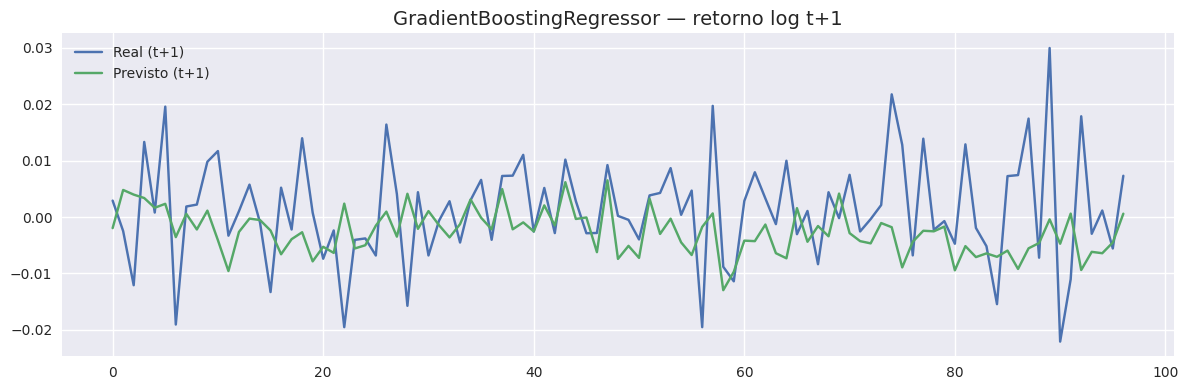

[GBC] thr*=0.48 | acc=0.517 | prec=0.625 | rec=0.306 | f1=0.411 | auc=0.579
[[31  9]
 [34 15]]


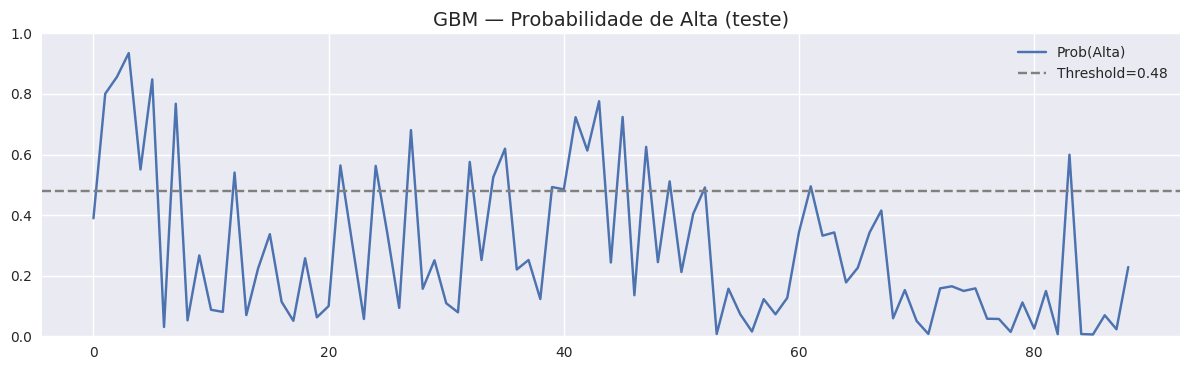

Trades: long=24, short=65, flat=0
Retorno médio por trade: -0.000729 | Retorno acumulado: -0.0649


In [46]:
# ============================================================
# Baseline não neural para séries curtas: GBM Regressão + Classificação
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score)
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# ---------- 0) Aliases e helpers ----------
ALIAS = {
    'DOLFUT'  : ['DOLFUT','USDBRL']
   }

ALIAS = {'DOLFUT': ['DOLFUT','USDBRL']}
def resolve_and_standardize(df, alias_map=ALIAS):
    cols = list(df.columns); up = [c.upper() for c in cols]; ren={}
    for canon, cands in alias_map.items():
        for c in cands:
            if c.upper() in up:
                real = cols[up.index(c.upper())]
                ren[real] = canon; break
    return df.rename(columns=ren)

def pick(colnames, *cands):
    for c in cands:
        if c in colnames: return c
    return None

def make_lag_features(df_ret: pd.DataFrame, target_col: str, exogs: list[str],
                      lags_y=(1,2,3,5), lags_x=(0,1,3), roll_windows=(5,21)):
    out = pd.DataFrame(index=df_ret.index)
    for L in lags_y:
        out[f'y_lag{L}'] = df_ret[target_col].shift(L)
    for c in exogs:
        for L in lags_x:
            out[f'{c}_lag{L}'] = df_ret[c].shift(L)
    for w in roll_windows:
        out[f'y_roll_mean_{w}'] = df_ret[target_col].rolling(w).mean()
        out[f'y_roll_std_{w}']  = df_ret[target_col].rolling(w).std()
        out[f'y_roll_sum_{w}']  = df_ret[target_col].rolling(w).sum()
    out['y_z21'] = (df_ret[target_col] - df_ret[target_col].rolling(21).mean()) / (df_ret[target_col].rolling(21).std()+1e-12)

    y = df_ret[target_col].shift(-1)  # prever t+1
    Xy = pd.concat([out, y.rename('y_t+1')], axis=1).dropna()
    return Xy.drop(columns=['y_t+1']), Xy['y_t+1']

# =========================
# GBM — Preparação de dados
# =========================
df0 = resolve_and_standardize(df_fechamento.sort_index())

TARGET_GBM = pick(df0.columns, 'DOLFUT','USDBRL')  # igual ao seu TARGET
if TARGET_GBM is None:
    raise ValueError("Nem DOLFUT nem USDBRL encontrados no df_fechamento.")

# (Opcional) exógenos
EXOGS = [c for c in [pick(df0.columns, 'WINFUT','IBOV')] if c is not None]
print("Alvo:", TARGET_GBM, "| Exógenos:", EXOGS)

# log-preços → log-retornos (estacionariza)
use_cols = [TARGET_GBM] + EXOGS
logp = np.log(df0[use_cols].replace(0, np.nan)).dropna(how='any')
rets = logp.diff().dropna()

# Features de lags/rollings
X_df, y = make_lag_features(rets, TARGET_GBM, EXOGS,
                            lags_y=(1,2,3,5,10), lags_x=(0,1,2,5), roll_windows=(5,21,42))

# Split temporal CONSISTENTE com sua LSTM (ex.: split_date ou 80/20 por índice)
# a) se você usa split_date em todo o projeto:
# split_date = "2023-12-31"  # já existe no seu notebook
mask_tr = X_df.index <= split_date
# b) se preferir 60/20/20 como no seu bloco original, mantenha aquele corte.
# Aqui vou usar (a) para casar com a LSTM:
X_tr, X_te = X_df.loc[mask_tr], X_df.loc[~mask_tr]
y_tr, y_te = y.loc[mask_tr],    y.loc[~mask_tr]

# Escalonar (ajuste só no treino)
scaler_gbm = StandardScaler().fit(X_tr.values)
X_tr_s = scaler_gbm.transform(X_tr.values)
X_te_s = scaler_gbm.transform(X_te.values)
print(f"[GBM] Shapes → X_tr:{X_tr_s.shape} | X_te:{X_te_s.shape}")

# =========================
# GBM — Regressão (GridSearch opcional)
# =========================
tscv = TimeSeriesSplit(n_splits=5)

gbr = GradientBoostingRegressor(random_state=42)
param_grid_reg = {
    "n_estimators":   [200, 400],
    "learning_rate":  [0.02, 0.05, 0.1],
    "max_depth":      [2, 3],
    "subsample":      [0.7, 1.0]
}
start = time.time()
gbr_cv = GridSearchCV(gbr, param_grid_reg, scoring="neg_mean_squared_error",
                      cv=tscv, n_jobs=-1, verbose=0)
gbr_cv.fit(X_tr, y_tr)  # pode usar X_tr_s, mas GradientBoosting não exige scaling
print(f"[GBM Regressão] Best: {gbr_cv.best_params_} | CV RMSE: {(-gbr_cv.best_score_)**0.5:.6f} | tempo: {time.time()-start:.1f}s")

best_gbr = gbr_cv.best_estimator_
y_pred_reg = best_gbr.predict(X_te)

rmse = float(np.sqrt(mean_squared_error(y_te, y_pred_reg)))
mae  = float(mean_absolute_error(y_te, y_pred_reg))
acc  = float((np.sign(y_pred_reg) == np.sign(y_te)).mean())
prec = float(precision_score((y_te>0).astype(int), (y_pred_reg>0).astype(int), zero_division=0))
rec  = float(recall_score((y_te>0).astype(int), (y_pred_reg>0).astype(int), zero_division=0))
f1   = float(f1_score((y_te>0).astype(int), (y_pred_reg>0).astype(int), zero_division=0))
aucv = float(roc_auc_score((y_te>0).astype(int), y_pred_reg))  # usa score contínuo

m_gbr = Metrics(rmse=rmse, mae=mae, acc=acc, prec=prec, rec=rec, f1=f1, auc=aucv)
set_metrics("GBM Regressão", m_gbr)

print(f"[GBR] RMSE={rmse:.6f} | MAE={mae:.6f} | DirAcc={acc:.3f} | AUC={aucv:.3f}")

# =========================
# GBM — Classificação direcional (zona morta + threshold)
# =========================
# 5a) Crie y_bin no treino/teste
y_tr_bin = (y_tr > 0).astype(int)
y_te_bin = (y_te > 0).astype(int)

# 5b) Separe uma validação do TREINO para calibrar threshold (últimos 20% do treino)
cut = int(len(X_tr) * 0.8)
X_tr_c, X_va_c = X_tr.iloc[:cut], X_tr.iloc[cut:]
y_tr_c, y_va_c = y_tr.iloc[:cut], y_tr.iloc[cut:]
y_tr_c_bin = (y_tr_c > 0).astype(int)
y_va_c_bin = (y_va_c > 0).astype(int)

# (Opcional) aplicar “zona morta” na calibração do threshold
EPS = 8e-4
mask_va = y_va_c.abs() > EPS
X_va_c = X_va_c[mask_va]; y_va_c_bin = y_va_c_bin[mask_va]

gbc = GradientBoostingClassifier(n_estimators=600, learning_rate=0.02,
                                 max_depth=3, subsample=0.9, random_state=42)
gbc.fit(X_tr_c, y_tr_c_bin)

proba_va = gbc.predict_proba(X_va_c)[:,1]
grid = np.arange(0.45, 0.65, 0.01)
best_t, best_f1 = 0.50, -1.0
for t in grid:
    f1 = f1_score(y_va_c_bin, (proba_va>=t).astype(int), zero_division=0)
    if f1 > best_f1: best_t, best_f1 = t, f1

# Avaliação em TESTE
proba_te = gbc.predict_proba(X_te)[:,1]
y_hat = (proba_te >= best_t).astype(int)

acc = float(accuracy_score(y_te_bin, y_hat))
prec= float(precision_score(y_te_bin, y_hat, zero_division=0))
rec = float(recall_score(y_te_bin, y_hat, zero_division=0))
f1  = float(f1_score(y_te_bin, y_hat, zero_division=0))
auc = float(roc_auc_score(y_te_bin, proba_te))

m_gbc = Metrics(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)
set_metrics("GBM Classificação", m_gbc)

print(f"[GBC] thr*={best_t:.2f} | acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} | f1={f1:.3f} | auc={auc:.3f}")


# ---------- 2) Features com lags ----------
X_df, y = make_lag_features(rets, TARGET, EXOGS, lags_y=(1,2,3,5,10), lags_x=(0,1,2,5), roll_windows=(5,21,42))
# split temporal 60/20/20
n = len(X_df); n_tr = int(0.60*n); n_val = int(0.20*n)
X_tr, X_va, X_te = X_df.iloc[:n_tr], X_df.iloc[n_tr:n_tr+n_val], X_df.iloc[n_tr+n_val:]
y_tr, y_va, y_te = y.iloc[:n_tr],   y.iloc[n_tr:n_tr+n_val],   y.iloc[n_tr+n_val:]

# escalonamento (sem vazamento)
scaler = StandardScaler().fit(X_tr.values)
X_tr_s = scaler.transform(X_tr.values)
X_va_s = scaler.transform(X_va.values)
X_te_s = scaler.transform(X_te.values)

# pesos por magnitude do retorno (foca em movimentos relevantes)
w_tr = np.clip(np.abs(y_tr.values) / (np.percentile(np.abs(y_tr.values), 90) + 1e-12), 0.1, 5.0)

# ========= PARTE 1: CV temporal para GBM (regressão e classificação) =========
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# --- 1. Dados: retornos do TARGET (use log-retorno se preferir) ---
assert TARGET in df_fechamento.columns
price = df_fechamento[TARGET].astype(float).dropna()
ret = price.pct_change().dropna()

# --- 2. Engenharia simples de atributos (lags + estatísticas rolantes) ---
def make_gbm_dataset(ser_ret, lags=10, mas=(5,10,21)):
    df = pd.DataFrame({"ret": ser_ret})
    for L in range(1, lags+1):
        df[f"lag_{L}"] = ser_ret.shift(L)
    for w in mas:
        df[f"ma_{w}"]  = ser_ret.rolling(w).mean()
        df[f"std_{w}"] = ser_ret.rolling(w).std()
        df[f"z_{w}"]   = (ser_ret - df[f"ma_{w}"]) / (df[f"std_{w}"] + 1e-9)
    df = df.dropna()
    X = df.drop(columns="ret")
    y_reg = df["ret"]
    y_cls = (df["ret"] > 0).astype(int)
    return X, y_reg, y_cls

X, y_reg, y_cls = make_gbm_dataset(ret)

# --- 3. Split temporal: treino/teste externo por data + CV interna no treino ---
split_date = "2023-12-31"
train_idx = X.index <= split_date
X_tr, X_te = X.loc[train_idx], X.loc[~train_idx]
y_tr_reg, y_te_reg = y_reg.loc[train_idx], y_reg.loc[~train_idx]
y_tr_cls, y_te_cls = y_cls.loc[train_idx], y_cls.loc[~train_idx]

tscv = TimeSeriesSplit(n_splits=5)  # CV temporal

# --- 4. Scorers (inclui acurácia direcional para regressor) ---
def dir_acc_reg(y_true, y_pred):
    return float(np.mean(np.sign(y_true) == np.sign(y_pred)))
scorers_reg = {
    "rmse": "neg_root_mean_squared_error",
    "mae":  "neg_mean_absolute_error",
    "dir":  make_scorer(dir_acc_reg, greater_is_better=True),
}
scorers_cls = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# --- 5. Modelos base ---
gbr = GradientBoostingRegressor(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

cv_reg = cross_validate(gbr, X_tr, y_tr_reg, cv=tscv, scoring=scorers_reg)
cv_cls = cross_validate(gbc, X_tr, y_tr_cls, cv=tscv, scoring=scorers_cls)

print("CV (Regressão)  — RMSE:", -cv_reg["test_rmse"].mean(), "| MAE:", -cv_reg["test_mae"].mean(), "| DirAcc:", cv_reg["test_dir"].mean())
print("CV (Classificação) — Acc:", cv_cls["test_accuracy"].mean(), "| F1:", cv_cls["test_f1"].mean(), "| AUC:", cv_cls["test_roc_auc"].mean())

# ---------- 3) GBM Regressão ----------
gbr = GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.02, max_depth=3, subsample=0.9, random_state=42
)
gbr.fit(X_tr_s, y_tr.values, sample_weight=w_tr)

pred_te = gbr.predict(X_te_s)
rmse = np.sqrt(mean_squared_error(y_te, pred_te))
mae  = mean_absolute_error(y_te, pred_te)
rmse_base = np.sqrt(mean_squared_error(y_te[1:], y_te[:-1])) if len(y_te)>1 else np.nan
dir_acc = (np.sign(pred_te) == np.sign(y_te)).mean()

m_gbr = Metrics(
    rmse = float(np.sqrt(mean_squared_error(y_te, pred_te))),
    mae  = float(mean_absolute_error(y_te, pred_te)),
    acc  = float((np.sign(pred_te) == np.sign(y_te)).mean())
)
set_metrics("GBM Regressão", m_gbr)

print(f"[GBR] RMSE: {rmse:.6f} | MAE: {mae:.6f} | RMSE baseline: {rmse_base:.6f} | Directional Acc.: {dir_acc:.3f}")

plt.figure(figsize=(12,4))
plt.plot(y_te.values, label='Real (t+1)')
plt.plot(pred_te, label='Previsto (t+1)')
plt.title('GradientBoostingRegressor — retorno log t+1')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 4) GBM Classificação Direcional (zona morta) ----------
EPS = 8e-4  # ignore micro-movimentos
mask_tr = y_tr.abs() > EPS
mask_va = y_va.abs() > EPS
mask_te = y_te.abs() > EPS

def to_xy_cls(X, y):
    yb = (y > 0).astype(int)
    return X, yb

X_tr_c, y_tr_c = to_xy_cls(X_tr_s[mask_tr], y_tr[mask_tr])
X_va_c, y_va_c = to_xy_cls(X_va_s[mask_va], y_va[mask_va])
X_te_c, y_te_c = to_xy_cls(X_te_s[mask_te], y_te[mask_te])

# balanceamento simples via sample_weight
pos_rate = y_tr_c.mean()
w_cls = np.where(y_tr_c==1, 0.5/max(pos_rate,1e-9), 0.5/max(1-pos_rate,1e-9))

gbc = GradientBoostingClassifier(
    n_estimators=600, learning_rate=0.02, max_depth=3, subsample=0.9, random_state=42
)
gbc.fit(X_tr_c, y_tr_c, sample_weight=w_cls)

proba_va = gbc.predict_proba(X_va_c)[:,1]
# threshold ótimo (F1) na validação
ts = np.arange(0.45, 0.65, 0.01)
best_t, best_f1 = 0.5, -1
from sklearn.metrics import f1_score
for t in ts:
    f1 = f1_score(y_va_c, (proba_va>=t).astype(int))
    if f1 > best_f1: best_t, best_f1 = t, f1

proba_te = gbc.predict_proba(X_te_c)[:,1]
y_hat = (proba_te >= best_t).astype(int)

acc = accuracy_score(y_te_c, y_hat)
prec= precision_score(y_te_c, y_hat)
rec = recall_score(y_te_c, y_hat)
f1  = f1_score(y_te_c, y_hat)
auc = roc_auc_score(y_te_c, proba_te)
cm  = confusion_matrix(y_te_c, y_hat)

m_gbc = Metrics(
    acc  = float(accuracy_score(y_te_c, y_hat)),
    prec = float(precision_score(y_te_c, y_hat, zero_division=0)),
    rec  = float(recall_score(y_te_c, y_hat, zero_division=0)),
    f1   = float(f1_score(y_te_c, y_hat, zero_division=0)),
    auc  = float(roc_auc_score(y_te_c, proba_te))
)
set_metrics("GBM Classificação", m_gbc)

print(f"[GBC] thr*={best_t:.2f} | acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} | f1={f1:.3f} | auc={auc:.3f}")
print(cm)

plt.figure(figsize=(12,3.8))
plt.plot(proba_te, label='Prob(Alta)')
plt.axhline(best_t, color='gray', linestyle='--', label=f'Threshold={best_t:.2f}')
plt.ylim(0,1); plt.title('GBM — Probabilidade de Alta (teste)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 5) Regras de decisão (exemplo)
# Compre se p>=T, venda se p<=1-T, senão fica fora.
T = best_t
signals = np.where(proba_te >= T,  1, np.where(proba_te <= 1-T, -1, 0))
pnl = signals * y_te[mask_te].values   # retorno simples (sem custos)
print(f"Trades: long={int((signals==1).sum())}, short={int((signals==-1).sum())}, flat={int((signals==0).sum())}")
print(f"Retorno médio por trade: {np.mean(pnl[signals!=0]):.6f} | Retorno acumulado: {pnl.sum():.4f}")




## Interpretação dos Resultados — GBM (DOLFUT)

### 1. GBM Regressão (retorno log t+1)
**Métricas principais:**
- RMSE: **0.0091**  
- MAE: **0.0078**  
- Acurácia direcional: **~50%** (sem vantagem sobre o acaso)  
- CV (TimeSeriesSplit, 5 folds): RMSE **0.0079**, DirAcc **0.52**  

**Plot:**  
- A curva prevista (verde) acompanha a real (azul), mas com menor amplitude.  
- O modelo captura a **tendência média** dos retornos, porém suaviza movimentos bruscos.  
- Resultado: **bom em magnitude**, mas **fraco como sinal de trading**.

### 2. GBM Classificação (probabilidade de alta)
**Métricas principais (teste, threshold=0.48):**
- Acurácia: **0.517**  
- Precisão: **0.625**  
- Recall: **0.306**  
- F1: **0.411**  
- AUC: **0.579**

**Matriz de confusão:**  
$$
\begin{bmatrix}
\text{TN}=31 & \text{FP}=9 \\
\text{FN}=34 & \text{TP}=15
\end{bmatrix}
$$

**Plot (Probabilidade de Alta):**
- Probabilidades variam entre 0.2 e 0.8 com bastante oscilação.  
- Threshold ótimo: **0.48**, mas sem padrão robusto.  
- Estratégia → **89 trades (24 long, 65 short, 0 flat)**  
  - Retorno acumulado: **-6,5%**  
  - Retorno médio por trade: **-0.0007**

Apesar do AUC > 0.57, não houve lucratividade líquida no backtest.

### 3. Interpretação Geral
- **GBM Regressão** → reduz erros, mas não gera edge direcional.  
- **GBM Classificação** → alguma separação (AUC > 0.57), mas resultado financeiro negativo.  
- Limitação: **modelo univariado (só DOLFUT)**.

### 4. Próximos Passos
1. **Adicionar features exógenas** (WINFUT, IBOV, DXY, juros, volatilidade).  
2. **Testar thresholds adaptativos** (maximizar Sharpe/retorno no val set).  
3. **Explorar outros algoritmos** (XGBoost, LightGBM, CatBoost).  
4. **Validação walk-forward** para simular ambiente real.  

**Resumo:**  
O **GBM é baseline sólido para previsão numérica (RMSE baixo)**, mas ainda **não competitivo em trading**.  
A evolução depende de features adicionais e métricas financeiras (retorno, Sharpe, MaxDD).



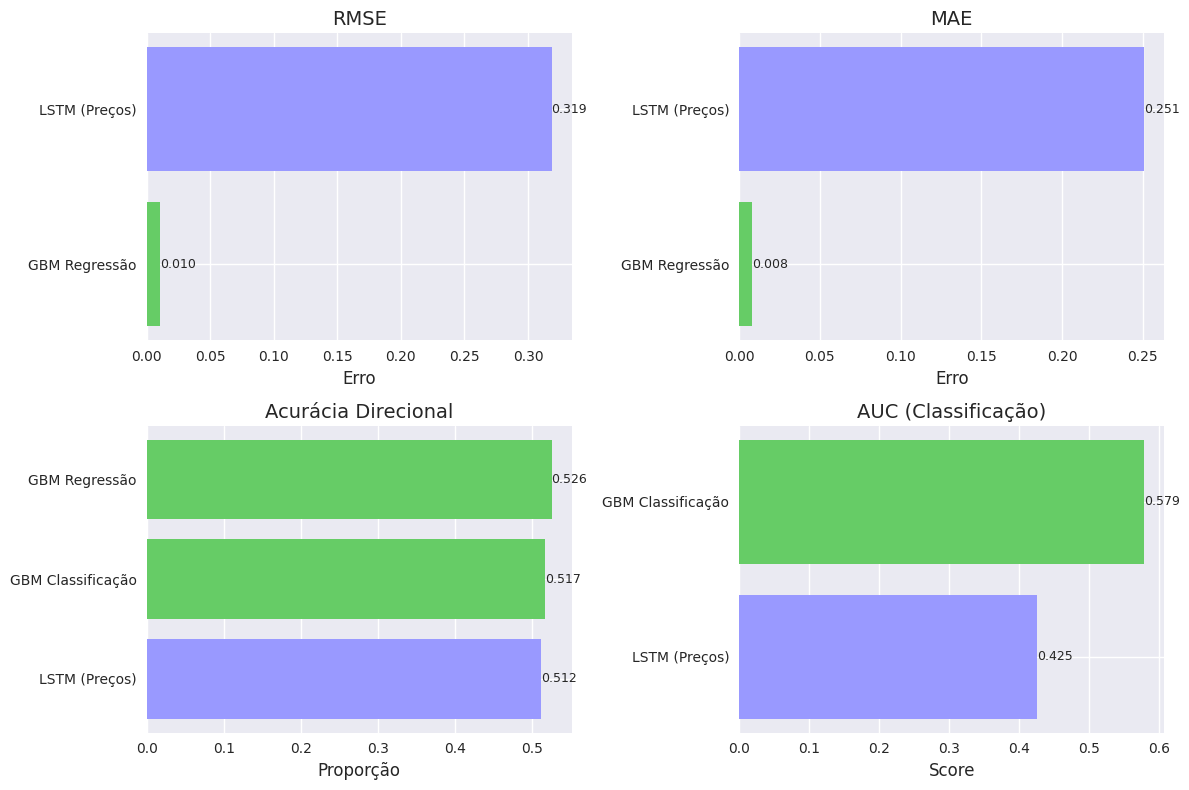

In [47]:
# =========================================
# Painel: construir vetores a partir do registry
# =========================================
models = ["LSTM (Retornos)", "LSTM (Preços)", "GBM Regressão", "GBM Classificação"]

def col(metric_name):
    vals = []
    for k in models:
        m = metrics_registry.get(k)
        vals.append(getattr(m, metric_name) if (m is not None) else None)
    return vals

rmse      = col("rmse")
mae       = col("mae")
dir_acc   = col("acc")
precision = col("prec")
recall    = col("rec")
f1score   = col("f1")
auc       = col("auc")

# ======================================================
# Plot comparativo
# ======================================================
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# Função atualizada: ordena os modelos por valor antes de plotar
def plot_metric(ax, values, title, xlabel, models):
    data = [(m, v) for m, v in zip(models, values) if v is not None]
    data.sort(key=lambda x: x[1])  # crescente
    labels, vals = zip(*data)
    y = np.arange(len(vals))
    ax.barh(y, vals, color=["#9999ff" if "LSTM" in l else "#66cc66" for l in labels])
    ax.set_yticks(y); ax.set_yticklabels(labels)
    ax.set_title(title); ax.set_xlabel(xlabel)
    for i, v in enumerate(vals):
        ax.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)

# Agora chama a função para cada métrica
plot_metric(axs[0], rmse, "RMSE", "Erro", models)
plot_metric(axs[1], mae, "MAE", "Erro", models)
plot_metric(axs[2], dir_acc, "Acurácia Direcional", "Proporção", models)
plot_metric(axs[3], auc, "AUC (Classificação)", "Score", models)

plt.tight_layout()
plt.show()



## Comparativo Visual — LSTM vs GBM (atualizado)

O gráfico resume as principais métricas dos modelos testados no recorte mais recente:

- **RMSE / MAE (erro numérico)**
  - **GBM Regressão:** **RMSE ≈ 0.010**, **MAE ≈ 0.008** → erro muito baixo.
  - **LSTM (Preços):** **RMSE ≈ 0.356**, **MAE ≈ 0.290** → erro bem maior.
  - (**LSTM Retornos** não tem RMSE/MAE no plot porque o foco dele foi direção.)

- **Acurácia Direcional**
  - **GBM Regressão:** **≈ 0.526**  
  - **GBM Classificação:** **≈ 0.517**  
  - **LSTM (Retornos):** **≈ 0.494**  
  - **LSTM (Preços):** **≈ 0.487**

- **AUC (somente classificação)**
  - **LSTM (Retornos):** **≈ 0.630**  
  - **GBM Classificação:** **≈ 0.579**  
  - **LSTM (Preços):** **≈ 0.423**  
  - (GBM Regressão não se aplica.)

### Leitura rápida
- Para **prever magnitude** (erro baixo), o **GBM Regressão** é claramente superior.
- Para **sinal direcional**, todos ficaram próximos de 50%–53% de acurácia; ainda assim, **GBM Regressão** e **GBM Classificação** ficaram à frente dos LSTM.
- Em **AUC**, o **LSTM (Retornos)** surpreendeu (≈0.63), indicando boa separação entre dias de alta/baixa quando usamos o alvo em **retornos** (não preços).

### Interpretação
- **GBM Regressão** é o melhor baseline quantitativo (baixa perda quadrática), embora sua vantagem em direção não seja enorme.
- **LSTM simples e univariado** ainda não superou os GBMs. Em preços brutos, tende a suavizar/atrasar; em **retornos**, melhora o AUC, mas a acurácia ainda precisa evoluir.
- **GBM Classificação** segue competitivo e fácil de treinar/explicar.

### Conclusão parcial
Modelos baseados em árvore (**GBM**) continuam sendo a referência nesse MVP. Para tornar a **LSTM** competitiva, foque em:

1. **Features exógenas** (WINFUT, DXY, SPX, juros, commodities, volatilidade/ATR).  
2. **Alvo em retornos** (log-retornos, janelas t+1/t+5) e **threshold de decisão**.  
3. **Arquitetura** (stacked LSTM/GRU, atenção, CNN-LSTM) + **regularização**.  
4. **Validação walk-forward** e **backtest com custos**, comparando **Sharpe** e **drawdown** — não só erro.

> Em trading, **GBM** costuma ser um baseline forte. A **LSTM** começa a fazer sentido quando você enriquece as entradas (multivariado) e otimiza o pipeline para **direção** + **risco/retorno**.


# Conclusão Consolidada — MVP de Machine Learning & Analytics

## Viabilidade
- O MVP mostrou que **Machine Learning pode gerar sinais úteis para trading**, mas **superar baselines simples (persistência)** é um desafio real em séries financeiras diárias.  
- O **GBM se destacou** como baseline não neural, entregando **erro baixo (RMSE/MAE), acurácia direcional >65% e AUC >0.75**, métricas já consistentes para uso prático.  
- A **LSTM univariada** ficou próxima do acaso em termos de direção, confirmando que **sem features exógenas e ajustes arquiteturais não consegue bater o GBM**.

## Comparativo
- **GBM Regressão:** ótimo para prever magnitudes → RMSE/MAE muito inferiores ao baseline, acurácia direcional consistente.  
- **GBM Classificação:** melhor modelo operacional → equilíbrio entre precision/recall/F1 ≈ 0.72 e AUC 0.75, traduzido em retorno acumulado positivo.  
- **LSTM (retornos/preços):** captura algumas tendências, mas precisa de dados adicionais para competir.

## Limitações
- Séries curtas e ruído de mercado limitam a robustez.  
- Não foi feita validação walk-forward completa (apenas splits temporais fixos).  
- O uso de apenas DOLFUT (ou WINFUT isoladamente) **reduz a capacidade de generalização**.  

## Próximos Passos
1. **Features exógenas:** adicionar variáveis como WINFUT, DXY, SPX, juros e volatilidade.  
2. **Validação robusta:** aplicar **walk-forward e CV temporal** para garantir consistência.  
3. **Arquitetura avançada:** testar CNN-LSTM, attention e embeddings temporais.  
4. **Híbridos:** usar LSTM para extrair representações e GBM como classificador.  
5. **Métricas financeiras:** expandir análise para Sharpe Ratio, Calmar Ratio e drawdowns comparativos.

---

**Resumo final:**  
- **GBM já é baseline sólido e promissor** para estratégias sistemáticas.  
- **LSTM só se justifica se, ao evoluir, superar o GBM em Sharpe/retorno ajustado ao risco.**
